## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [1]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import gc

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-gmr9oo3b because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [3]:
# # When loading ufo data
# #DATA_DIR = '.'
# current_directory = os.getcwd()
# print(current_directory)

# path_data_NLD = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-NLD.pkl')
# path_data_FRA = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-FRA.pkl')
# path_data_ESP = os.path.join('/workspace/workspace/ufo-prediction', 'demo', 'df-ESP.pkl')
# print(path_data_NLD)
# df = pd.read_pickle(path_data_NLD)


/workspace
/workspace/workspace/ufo-prediction/demo/df-NLD.pkl


In [3]:
path_data_NLD = os.path.join(dataset.DATA_DIR, 'ufo-CNN_ALL_weighted_loss2.csv')
df = pd.read_csv(path_data_NLD, encoding='latin1')

In [4]:
df['age']

0       1935.0
1       1938.0
2       1994.0
3       2016.0
4       1912.0
         ...  
2160    1900.0
2161    2014.0
2162    1982.0
2163    1900.0
2164    1965.0
Name: age, Length: 2165, dtype: float64

In [5]:
df.drop(columns=['Predicted Class', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6'])

,id,source_file,dist_to_closest_int,av_footprint_area_within_buffer_100,street_betweeness_global_max_within_buffer_500,av_elongation_within_buffer_500,geometry,std_building_footprint_city,block,blocks_2_to_4,...,street_betweeness_global_max_within_buffer_100,TouchesIndexes,street_based_block_av_phi_inter_buffer_500,total_length_street_city,total_buildings_footprint_city,Phi,street_based_block_std_area_inter_buffer_100,type,neighborhood,_merge
0,v0.1-NLD.1.11_1-19088,NL_lod12_2d_pand_2,34.004043,136.310103,0.056066,0.700286,POINT (4089902.86562824 3337390.9283716725),424.396815,8502c112,3121.0,...,0.056066,[19088],0.337143,8.887122e+05,2.887787e+06,0.551174,5.975969e+05,NaN,547d1be9,both
1,v0.1-NLD.1.1_1-13644,NL_lod12_2d_pand_2,34.802679,150.671818,0.037504,0.667447,POINT (4097391.282609189 3319500.669323659),318.422938,1ac7cd76,2369.0,...,0.037504,[13644],0.396432,1.013007e+06,2.966798e+06,0.598186,5.294541e+05,NaN,a50451ac,both
2,v0.1-NLD.1.2_1-21267,NL_lod12_2d_pand_2,30.015530,66.159471,0.039280,0.671473,POINT (4092560.009249362 3328818.652171437),386.512231,00bbf577,5907.0,...,0.019270,[21267],0.378814,7.084962e+05,3.936964e+06,0.504573,4.913307e+05,NaN,4108f866,both
3,v0.1-NLD.1.2_1-6956,NL_lod12_2d_pand_2,34.409625,68.807621,0.059310,0.650032,POINT (4092072.969534574 3328467.59053146),386.512231,9df37120,5907.0,...,0.020112,[6956],0.325508,7.084962e+05,3.936964e+06,0.618989,4.843252e+05,NaN,cb92baa3,both
4,v0.1-NLD.1.3_1-11744,NL_lod12_2d_pand_2,180.861945,102.209350,0.063660,0.679412,POINT (4106558.5323021677 3315162.66905548),291.783127,5d5ec3b7,2231.0,...,0.062462,[11744],0.225806,9.779260e+05,3.148352e+06,0.516409,6.590574e+06,NaN,f93411d6,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160,v0.1-FRA.9.4.3.8_1-3382,BATIMENT-normandie,10.419062,156.877435,0.202879,0.618930,POINT (3624640.868626991 2866861.1434332132),334.386680,ddab9ec1,1530.0,...,0.087577,"[3381, 8032, 8033, 3382]",0.286737,6.584433e+05,1.485116e+06,0.517742,2.536565e+05,residential,efceeee8,both
2161,v0.1-FRA.9.5.1.17_1-2783,BATIMENT-normandie,19.357133,713.155023,0.078554,0.620819,POINT (3681680.5718504316 3014974.636037273),335.660743,4cc30110,3208.0,...,0.032128,[2783],0.288695,7.053070e+05,2.097088e+06,0.510567,8.486095e+05,non-residential,08af5f7a,both
2162,v0.1-FRA.9.5.1.18_1-2888,BATIMENT-normandie,309.291174,86.385713,0.071819,0.564067,POINT (3691294.484158149 2984507.3673956036),163.432429,0b240dae,1669.0,...,0.057448,[2888],0.217120,5.843162e+05,1.076556e+06,0.598157,2.318356e+06,non-residential,a667c6dc,both
2163,v0.1-FRA.9.5.3.1_1-4383,BATIMENT-normandie,54.905718,41.200264,0.100350,0.637776,POINT (3677525.6511533055 2966201.848477324),236.087258,47081ce8,2816.0,...,0.016444,"[901, 5838, 13990, 1492, 7772, 1426, 9716, 583...",0.290407,5.117132e+05,1.427673e+06,0.580948,1.577956e+05,residential,8bbe4115,both


In [6]:
df = df.rename(columns={'age': 'age_right'})


In [7]:
print(len(df))

2165


## Prediction

In [8]:
xgb_model_params = {'tree_method': 'hist', 
                    # 'n_estimators': 500
                    }
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

2024-04-19 14:56:11,351 | INFO : Dataset length: 2165
2024-04-19 14:56:11,356 | INFO : Dataset allocated memory: 2 MB
2024-04-19 14:56:11,360 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-18862087.abort.
2024-04-19 14:56:11,361 | INFO : Dataset standard deviation: 31.791831041561366
2024-04-19 14:56:11,362 | INFO : Dataset mean age: 1963.469284064665
2024-04-19 14:56:11,362 | INFO : Training dataset length: 1732
2024-04-19 14:56:11,363 | INFO : Test dataset length: 433
2024-04-19 14:56:11,378 | INFO : Test dataset standard deviation after preprocessing: 29.435443607657565
2024-04-19 14:56:11,379 | INFO : Test dataset mean age after preprocessing: 1966.9690476190476
2024-04-19 14:56:11,380 | INFO : Training dataset length after preprocessing: 1654
2024-04-19 14:56:11,380 | INFO : Test dataset length after preprocessing: 420
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, u

MAE: 20.44 y
RMSE: 25.93 y
R2: 0.2220
Energy need for heating in kWh/(m²a) R2: nan
Energy need for heating in kWh/(m²a) MAPE: nan


FixedFormatter should only be used together with FixedLocator


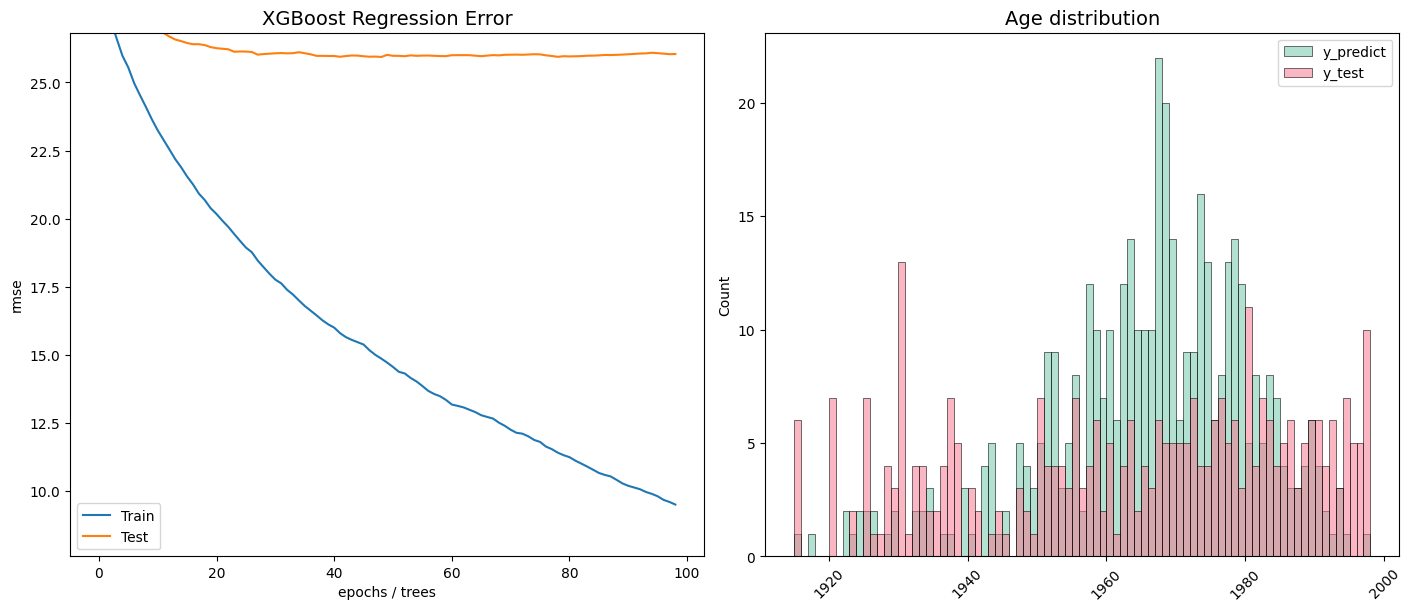

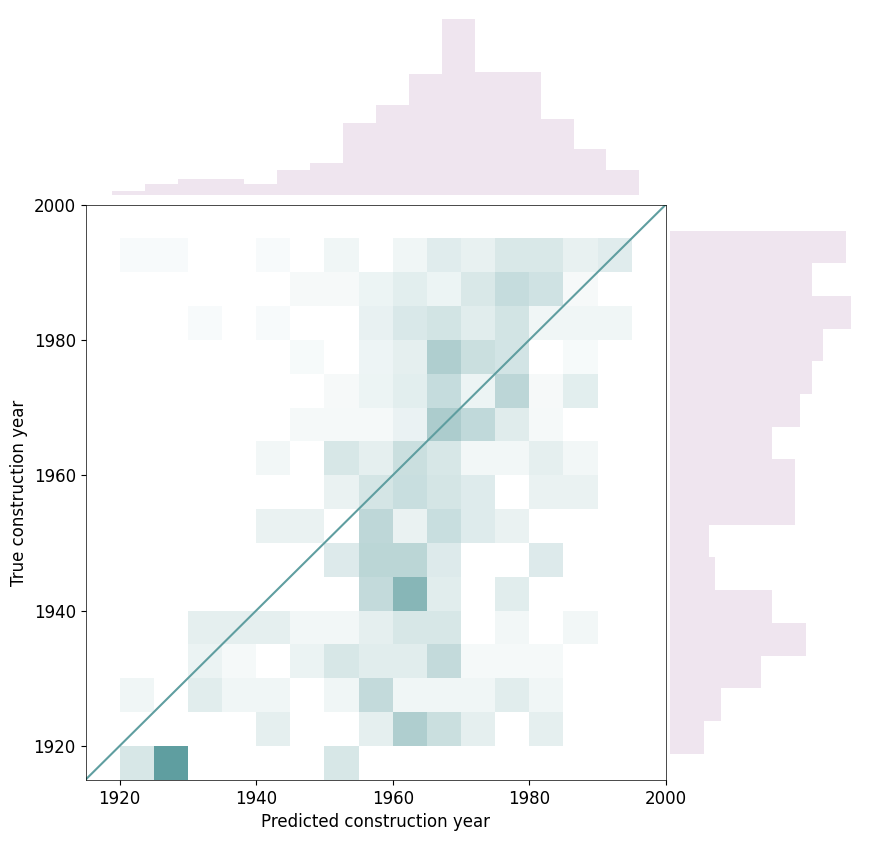

In [9]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    # preprocessing_stages=[pp.remove_outliers, pp.categorical_to_int_byList, pp.convert_to_double_byList]
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


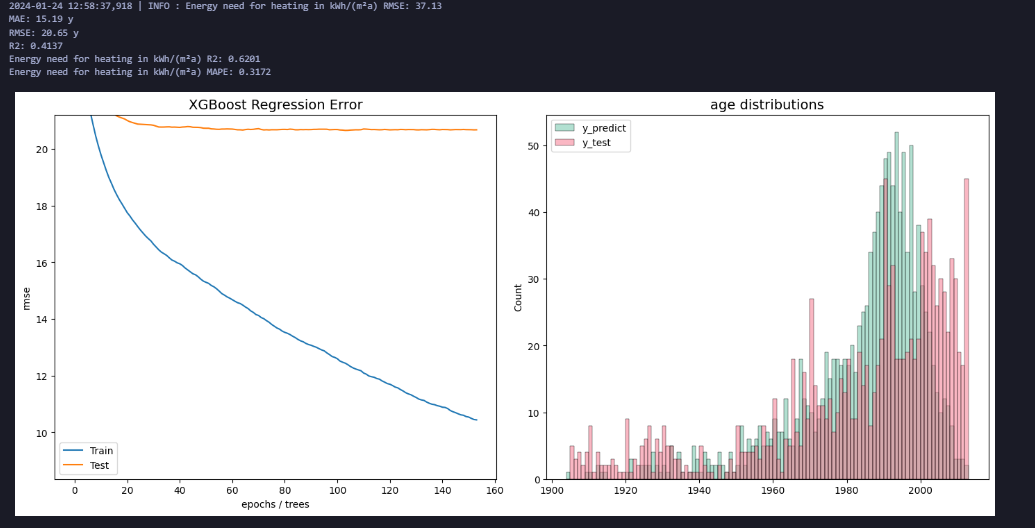
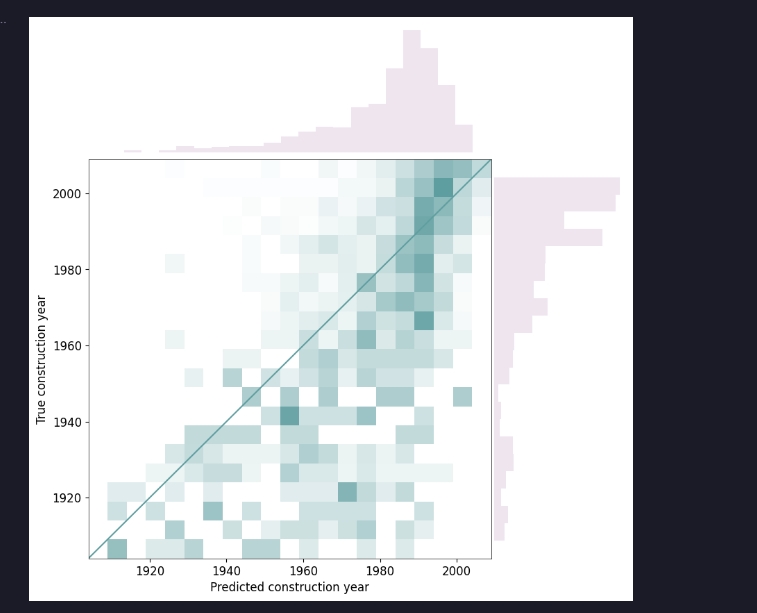

### Classification

2024-04-19 14:56:57,632 | INFO : Generated bins: [1900, 1945, 1970, 1980, 1990, 2000, 2010, 2051]
2024-04-19 14:56:57,634 | INFO : Generated bins with the following labels: ['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050']
2024-04-19 14:56:57,638 | INFO : Dataset length: 2165
2024-04-19 14:56:57,644 | INFO : Dataset allocated memory: 2 MB
2024-04-19 14:56:57,648 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-8be778b4.abort.
2024-04-19 14:56:57,648 | INFO : Training dataset length: 1732
2024-04-19 14:56:57,649 | INFO : Test dataset length: 433
2024-04-19 14:56:57,650 | INFO : Test cities: ['Barcelona' 'Amsterdam' 'Venlo' 'Noordoostpolder' 'Narbonne' 'Hulst'
 "L'Arbresle" 'Maarssen' 'Madrid' 'Sevilla' 'LituÃ©nigo'
 'Puerto del Rosario' "L'Isle-Jourdain (Occitanie)" 'Dijon  2e  Canton'
 'Waalwijk' 'Almelo' 'Groningen' 'Twenterand' 'El Pino de Tormes'
 'San BartolomÃ© de Tirajana' 'Zw

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


Classification report:
               precision    recall  f1-score  support
1900-1944      0.558559  0.590476  0.574074      105
1945-1969      0.473684  0.489130  0.481283       92
1970-1979      0.258065  0.307692  0.280702       52
1980-1989      0.258065  0.140351  0.181818       57
1990-1999      0.321429  0.321429  0.321429       56
2000-2009      0.100000  0.119048  0.108696       42
2010-2050      0.133333  0.125000  0.129032       16
accuracy       0.371429  0.371429  0.371429        0
macro avg      0.300448  0.299018  0.296719      420
weighted avg   0.368309  0.371429  0.367014      420
Cohen’s kappa: 0.2381
Matthews correlation coefficient (MCC): 0.2389


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


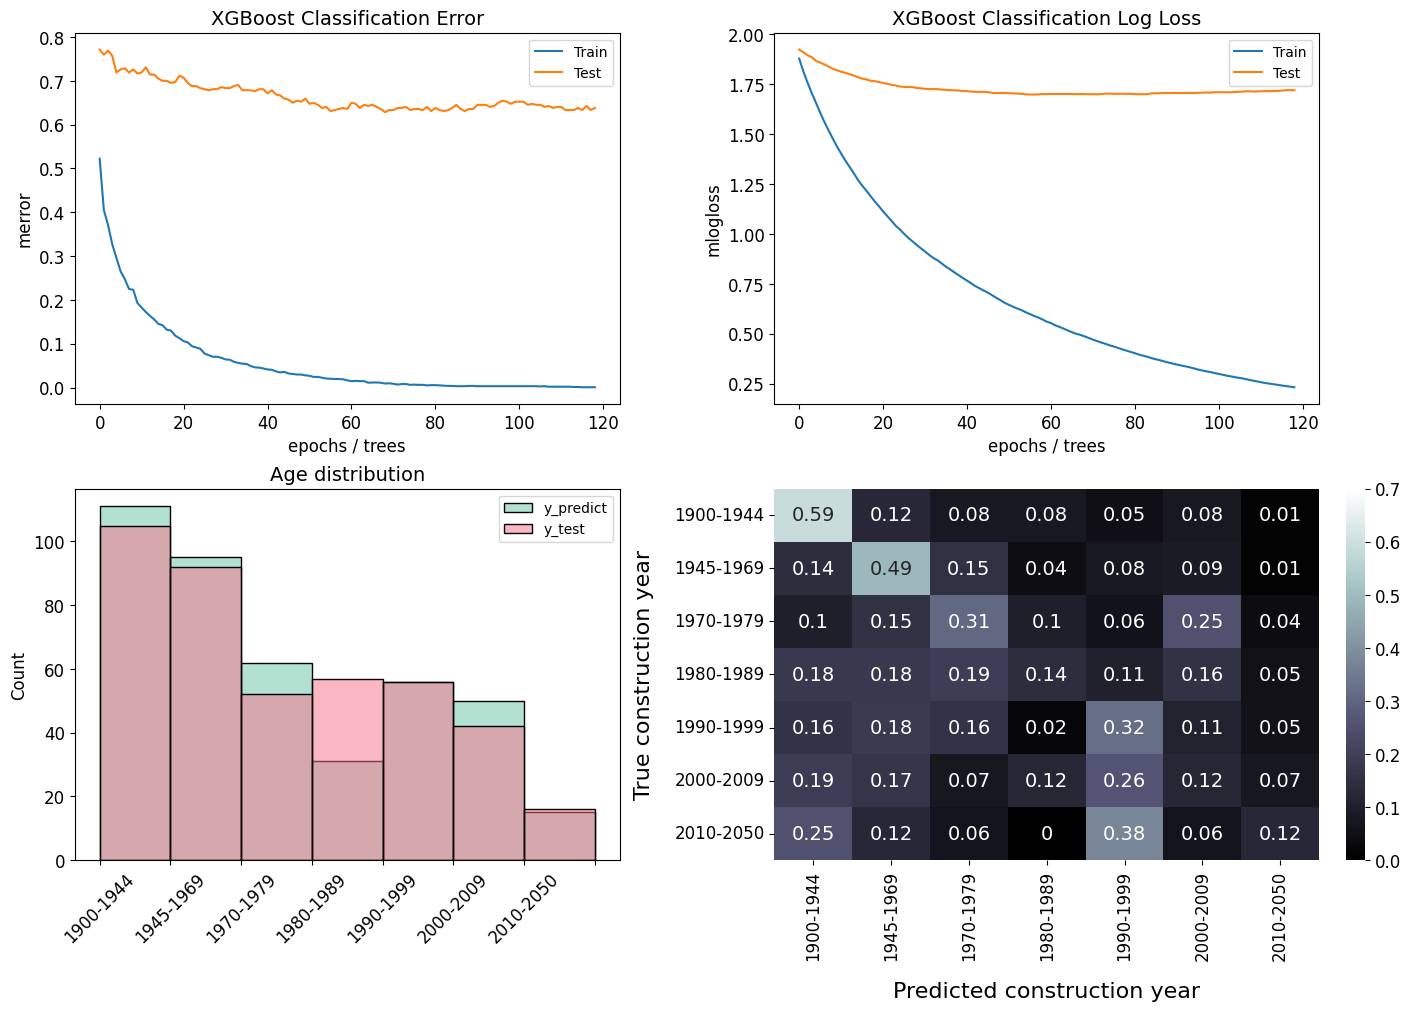

In [10]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = [1900, 1945, 1970, 1980, 1990, 2000, 2010, 2051]

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=equally_sized_bins,
)
classifier.evaluate(vmax=0.7)

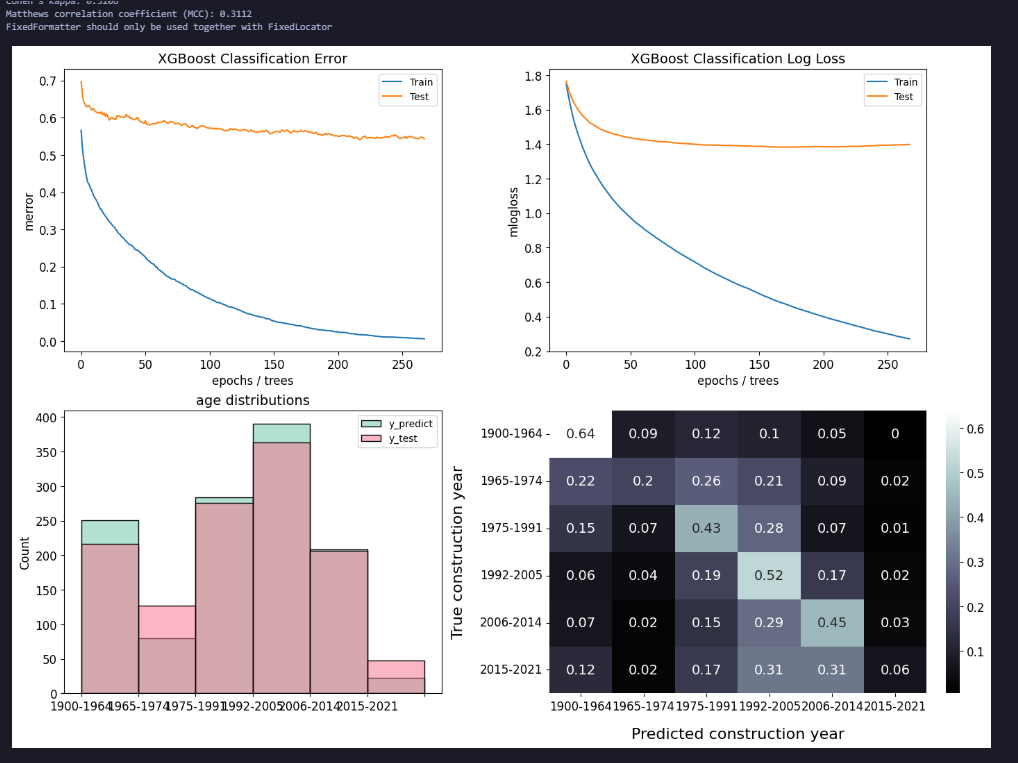

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [21]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2024-01-17 14:50:47,195 | INFO : Starting experiment Spain_random-cv...


2024-01-17 14:53:18,314 | INFO : Dataset length: 4226188
2024-01-17 14:53:18,319 | INFO : Dataset allocated memory: 4385 MB
2024-01-17 14:53:20,237 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-33f2404e.abort.
2024-01-17 14:53:20,256 | INFO : Dataset standard deviation: 48.35942318636823
2024-01-17 14:53:20,263 | INFO : Dataset mean age: 1971.7313162594755
2024-01-17 14:53:20,264 | INFO : Training dataset length: 3380950
2024-01-17 14:53:20,264 | INFO : Test dataset length: 845238
2024-01-17 14:53:33,818 | INFO : Test dataset standard deviation after preprocessing: 25.909066171213233
2024-01-17 14:53:33,820 | INFO : Test dataset mean age after preprocessing: 1980.6306878251494
2024-01-17 14:53:33,821 | INFO : Training dataset length after preprocessing: 3058384
2024-01-17 14:53:33,821 | INFO : Test dataset length after preprocessing: 764264
`early_stopping_rounds` in `fit` method is deprecated for better compatibility

FileNotFoundError: [Errno 2] No such file or directory: '/workspace/workspace/ufo-prediction/demo/df-FRA.pkl'

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725


In [ ]:
del comparison, predictor, classifier, results, df, df_temp, df_temp2, df_dropped
gc.collect()